## Comparison of the genetic load caused by introgressed and non-introgressed alleles

_Genetic load_ is the relative reduction in average fitness caused by deleterious alleles compared to the maximum absolute fitness.

I considered three models (example in the plot bellow):

* classic Gravel et al. demographic model
* model of a constant $N_e = 10000$
* model of an initial linear growth until $N_e = 10000$ followed by a period exponential growth

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lazyeval))
suppressPackageStartupMessages(library(reshape2))

suppressPackageStartupMessages(source("../R/process_slim_output.R"))

Conflicts with tidy packages ---------------------------------------------------


In [2]:
traject_dir <- "../simulations/different_models"

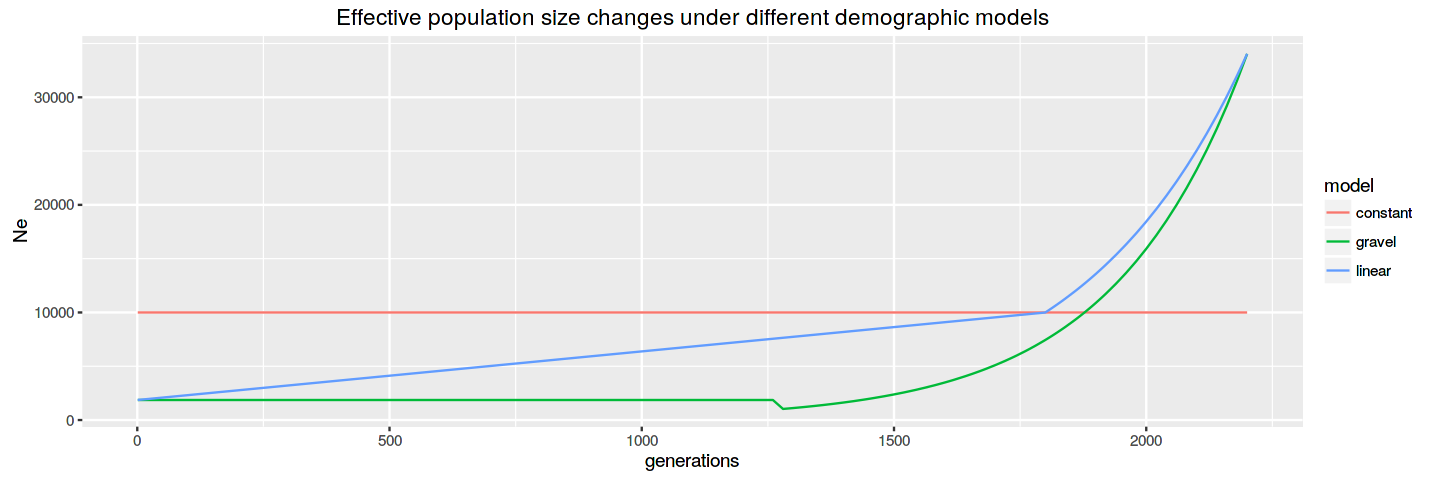

In [3]:
options(repr.plot.width=12, repr.plot.height=4)

# the custom SLiM output format includes a column with a Ne at each time-point
# this simply plots the values in this column for different simulation replicates
rbind(
    read.table(file.path(traject_dir, "constant__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE) %>% mutate(model="constant"),
    read.table(file.path(traject_dir, "gravel__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="gravel"),
    read.table(file.path(traject_dir, "linear__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="linear")
) %>%
ggplot(aes(gen, Ne, color=model)) +
    geom_line() +
    labs(title="Effective population size changes under different demographic models",
         x="generations")

In [4]:
slim_file <- read_slim_file("../simulations/different_models/gravel__h_0.5__init_nea_0.1__rep_1__dump_gen2.txt")

In [5]:
# load Neanderthal- and MH-specific deleterious variants segregating
# in the MH population
nea_muts <- read_mutations(slim_file, "m0", "p2")
mh_muts <- read_mutations(slim_file, "m0", "p1", t=50000)

In [6]:
# load tables with IDs of all MH individuals and their genomes
mh_indivs <- read_individuals(slim_file, "p3")
mh_genomes <- read_genomes(slim_file, "p3")

In [7]:
# match each mutation in each individual genome against its
# selection coefficient and other data
nea_muts_per_genome <- inner_join(mh_genomes, nea_muts, by="mut_id")
mh_muts_per_genome <- inner_join(mh_genomes, mh_muts, by="mut_id")

In [8]:
# calculate individual genetic loads caused by Nea variants
nea_loads <- tibble(
    indiv_id=mh_indivs$indiv_id,
    load=sapply(mh_indivs$indiv_id, calculate_indiv_load, muts_per_genome=nea_muts_per_genome),
    kind="Nea"
)

In [9]:
# calculate individual genetic loads caused by Nea variants
nea_loads <- tibble(
    indiv_id=mh_indivs$indiv_id,
    load=sapply(mh_indivs$indiv_id, calculate_indiv_load, muts_per_genome=nea_muts_per_genome),
    kind="Nea"
)

# calculate individual genetic loads caused by MH variants
mh_loads <- tibble(
    indiv_id=mh_indivs$indiv_id,
    load=sapply(mh_indivs$indiv_id, calculate_indiv_load, muts_per_genome=mh_muts_per_genome),
    kind="MH"
)

In [10]:
indiv_loads <- bind_rows(nea_loads, mh_loads)

In [11]:
options(repr.plot.width=8, repr.plot.height=4)

Warning message:
“Removed 816 rows containing missing values (geom_point).”

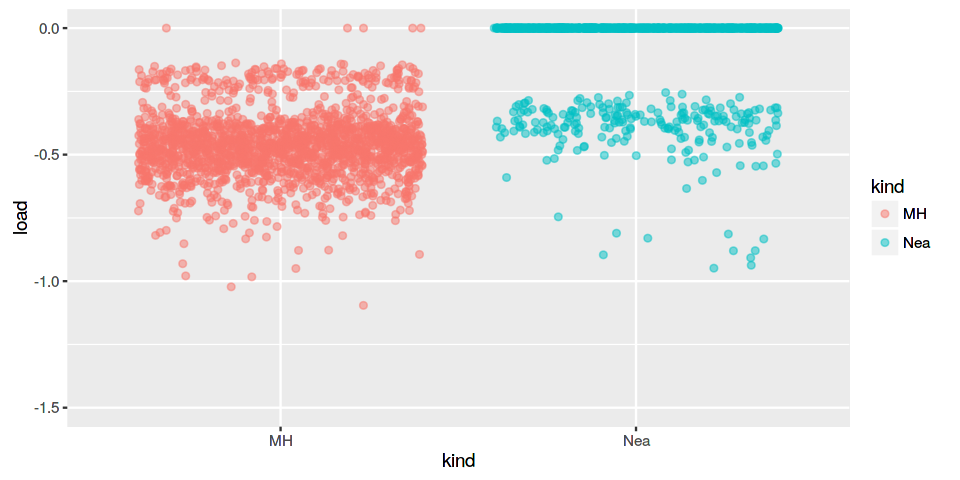

In [32]:
ggplot(indiv_loads, aes(kind, load)) +
    geom_jitter(aes(color=kind), alpha=0.5) +
    ylim(-1.5, 0)

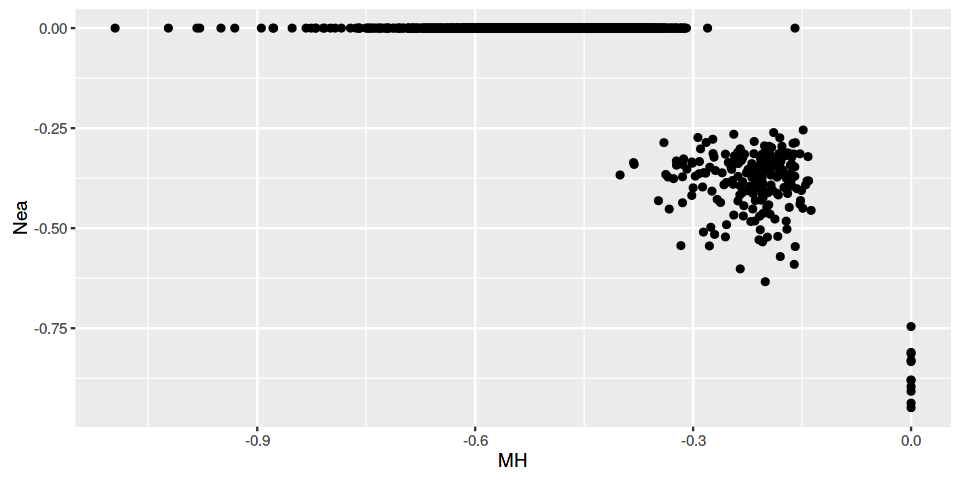

In [29]:
spread(indiv_loads, kind, load) %>%
ggplot(aes(MH, Nea)) + geom_point()

### Load the SLiM simulation output files for each model at different timepoints

This is a lot of data to parse (~57Gb), so we're going to do this in parallel.

In [4]:
library(parallel)

In [5]:
(gens <- c(1:50))
(models <- c("constant", "linear", "gravel"))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50

[1] "constant" "linear"   "gravel"

Load the exonic and nonexonic mutations in all specified generations for all three models:

In [6]:
combinations <- expand.grid(gen=gens, model=models)

In [ ]:
loads_list <-
    mclapply(
        1 : nrow(combinations),
        function(i) {
            model <- combinations[i, "model"]
            gen <- as.integer(combinations[i, "gen"])

            # load the whole SLiM output file first
            slim_file <- read_slim_file(file.path(traject_dir,
                                                  paste0(model,
                                                         "__h_0.5__init_nea_0.1__rep_1__dump_gen",
                                                         gen,
                                                         ".txt")))

            # load Neanderthal- and MH-specific deleterious variants segregating
            # in the MH population
            nea_muts <- read_mutations(slim_file, "m0", "p2")
            mh_muts <- read_mutations(slim_file, "m0", "p1", t=50000)
            
            # load tables with IDs of all MH individuals and their genomes
            mh_indivs <- read_individuals(slim_file, "p3")
            mh_genomes <- read_genomes(slim_file, "p3")
            
            # match each mutation in each individual genome against its
            # selection coefficient and other data
            nea_muts_per_genome <- inner_join(mh_genomes, nea_muts, by="mut_id")
            mh_muts_per_genome <- inner_join(mh_genomes, mh_muts, by="mut_id")

            # calculate individual genetic loads caused by Nea variants
            nea_loads <- tibble(
                indiv_id=mh_indivs$indiv_id,
                load=sapply(mh_indivs$indiv_id, calculate_indiv_load, muts_per_genome=nea_muts_per_genome),
                kind="Nea"
            )

            # calculate individual genetic loads caused by MH variants
            mh_loads <- tibble(
                indiv_id=mh_indivs$indiv_id,
                load=sapply(mh_indivs$indiv_id, calculate_indiv_load, muts_per_genome=mh_muts_per_genome),
                kind="MH"
            )

            bind_rows(nea_loads, mh_loads) %>% mutate(gen=gen, model=model)
            
        },
        mc.cores=detectCores()
    )

loads <- bind_rows(loads_list) %>% mutate(gen=factor(gen))
saveRDS(loads, "../tmp/loads.Rds")

Warning message in selectChildren(pids, 0.5):
“error 'Bad file descriptor' in select”

In [ ]:
#loads <- readRDS("../tmp/loads.Rds")